In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

C:\Users\Hasmi\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import pandas as pd
df = pd.read_csv("spam (1).csv")
df.head(5)

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [3]:
df.groupby('Category').describe()

Message                                                            \
           count unique                                                top   
Category                                                                     
ham         4825   4516                             Sorry, I'll call later   
spam         747    641  Please call our customer service representativ...   

               
         freq  
Category       
ham        30  
spam        4

In [4]:
df['Category'].value_counts()

ham     4825
spam     747
Name: Category, dtype: int64

In [6]:
747/4825

0.15481865284974095

15% spam emails, 85% ham emails: This indicates class imbalance.

In [7]:
df_spam = df[df['Category']=='spam']
df_spam.shape

(747, 2)

In [8]:
df_ham = df[df['Category']=='ham']
df_ham.shape

(4825, 2)

In [11]:
df_spam_oversampled = df_spam.sample(df_ham.shape[0], replace = True)
df_spam_oversampled.shape

(4825, 2)

In [13]:
df_balanced = pd.concat([df_spam_oversampled, df_ham])
df_balanced.shape

(9650, 2)

In [14]:
df_balanced['Category'].value_counts()

spam    4825
ham     4825
Name: Category, dtype: int64

In [15]:
df_balanced['spam']=df_balanced['Category'].apply(lambda x: 1 if x=='spam' else 0)
df_balanced.sample(5)

,Category,Message,spam
1463,spam,09066362231 URGENT! Your mobile No 07xxxxxxxxx...,1
5397,ham,That's necessarily respectful,0
5434,ham,Jesus armand really is trying to tell everybod...,0
959,ham,My sort code is and acc no is . The bank is n...,0
3451,ham,Ya just telling abt tht incident..,0


Split it into training and test data set

In [16]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_balanced['Message'],df_balanced['spam'], stratify=df_balanced['spam'])

In [17]:
X_train.head(4) 

3954    Refused a loan? Secured or Unsecured? Can't ge...
4728    Had your mobile 10 mths? Update to the latest ...
195     How are you doing? Hope you've settled in for ...
1938    The fact that you're cleaning shows you know w...
Name: Message, dtype: object

 Import BERT model and get embeding vectors for few sample statements

In [18]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [19]:
def get_sentence_embeding(sentences):
    preprocessed_text = bert_preprocess(sentences)
    return bert_encoder(preprocessed_text)['pooled_output']

get_sentence_embeding([
    "1000Rs discount. hurry up", 
    "Hasmita, are you up for a football game tomorrow?"]
)

<tf.Tensor: shape=(2, 768), dtype=float32, numpy=
array([[-0.88498014, -0.56358063, -0.9602954 , ..., -0.858255  ,
        -0.7922845 ,  0.9315395 ],
       [-0.8441965 , -0.58440185, -0.9882719 , ..., -0.9605481 ,
        -0.7082038 ,  0.7653214 ]], dtype=float32)>

Get embeding vectors for few sample words. Compare them using cosine similarity

In [27]:
ex = get_sentence_embeding([
    "banana", 
    "grapes",
    "orange",
    "jeff bezos",
    "elon musk",
    "bill gates"
]
)

In [28]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_similarity([ex[0]],[ex[1]])

array([[0.9911088]], dtype=float32)

In [29]:
cosine_similarity([ex[0]],[ex[3]])

array([[0.8470387]], dtype=float32)

Build Model
There are two types of models that can be built in tensorflow.

(1) Sequential (2) Functional

Here, we will build functional model.

In [30]:
# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural network layers
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs = [l])

https://stackoverflow.com/questions/47605558/importerror-failed-to-import-pydot-you-must-install-pydot-and-graphviz-for-py

In [31]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_mask': (Non  0           ['text[0][0]']                   
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128)}                                                  

In [32]:
len(X_train)

7237

In [33]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)

Train the model

In [34]:
model.fit(X_train, y_train, epochs=10)

Epoch 1/10
227/227 [==============================] - 1175s 5s/step - loss: 0.4622 - accuracy: 0.8070 - precision: 0.8007 - recall: 0.8173
Epoch 2/10
227/227 [==============================] - 1067s 5s/step - loss: 0.3003 - accuracy: 0.9009 - precision: 0.8913 - recall: 0.9132
Epoch 3/10
227/227 [==============================] - 1109s 5s/step - loss: 0.2516 - accuracy: 0.9157 - precision: 0.9076 - recall: 0.9256
Epoch 4/10
227/227 [==============================] - 32799s 145s/step - loss: 0.2210 - accuracy: 0.9281 - precision: 0.9263 - recall: 0.9303
Epoch 5/10
227/227 [==============================] - 1054s 5s/step - loss: 0.2017 - accuracy: 0.9337 - precision: 0.9320 - recall: 0.9356
Epoch 6/10
227/227 [==============================] - 1076s 5s/step - loss: 0.1834 - accuracy: 0.9410 - precision: 0.9421 - recall: 0.9397
Epoch 7/10
227/227 [==============================] - 1093s 5s/step - loss: 0.1735 - accuracy: 0.9471 - precision: 0.9489 - recall: 0.9450
Epoch 8/10
227/227 [====

In [35]:
model.evaluate(X_test, y_test)

76/76 [==============================] - 372s 5s/step - loss: 0.1220 - accuracy: 0.9644 - precision: 0.9730 - recall: 0.9553


[0.1220477893948555, 0.964359700679779, 0.9729957580566406, 0.9552609920501709]

In [38]:
y_predicted = model.predict(X_test)
y_predicted = y_predicted.flatten()

76/76 [==============================] - 378s 5s/step


In [39]:
import numpy as np

y_predicted = np.where(y_predicted > 0.5, 1, 0)
y_predicted[:10]

array([0, 0, 0, 1, 1, 0, 1, 0, 1, 0])

In [40]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, y_predicted)
cm 

array([[1174,   32],
       [  54, 1153]], dtype=int64)

Text(33.0, 0.5, 'Truth')

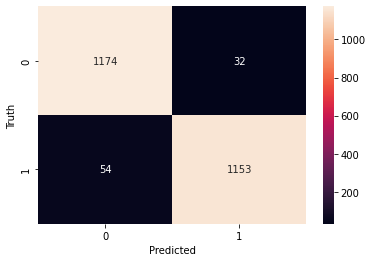

In [41]:
from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [42]:
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.96      0.97      0.96      1206
           1       0.97      0.96      0.96      1207

    accuracy                           0.96      2413
   macro avg       0.96      0.96      0.96      2413
weighted avg       0.96      0.96      0.96      2413



In [44]:
reviews = [
    'Enter a chance to win Rs5000, hurry up, offer valid until august 31, 2024',
    'You are awarded a Canon Digital Camera! call 08071331071 from landline. Delivery within 30days. T Cs Box177. M221BP. 2yr warranty. 150ppm. 16 . p pÂ£3.99',
    'it to 81488. Your 700 free text messages are valid until 31 December 2025.',
    'Hey Aaryan, Are you coming for a cricket game tomorrow',
    "Why don't you wait 'til at least wednesday to see if you get your discount."
]
model.predict(reviews)

1/1 [==============================] - 3s 3s/step


array([[0.9303963 ],
       [0.9660584 ],
       [0.9381819 ],
       [0.6482343 ],
       [0.03456648]], dtype=float32)